In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-retention/data.csv


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import scipy
import scipy.sparse 
from scipy.stats import pearsonr
from sklearn.feature_selection import chi2
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, jaccard_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, validation_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn import  metrics

In [3]:
df=pd.read_csv('/kaggle/input/customer-retention/data.csv')

**Sources:** 

* https://www.predictiveanalyticsworld.com/machinelearningtimes/uplift-modeling-predictive-analytics-cant-optimize-marketing-decisions-without-it/
* https://www.kaggle.com/code/davinwijaya/uplift-modeling-qini-curve-with-python
* https://towardsdatascience.com/a-quick-uplift-modeling-introduction-6e14de32bfe0
*  https://www.ambiata.com/blog/2020-07-07-uplift-modeling/



# **UPLIFT MODELING**  
Analytically modeling to predict the influence on a customer's buying behavior that results from choosing one marketing treatment (customer-facing action) over another. The secondary treatment is often passive – make no contact – as evaluated over a control group. The uplift model answers the question, “How much more likely is this treatment to generate the desired outcome than the alternative treatment?” For each customer, the model's prediction drives the decision of which treatment to apply.

**Decision between treatments**
Should we contact the customer or not (active or passive treatment)?

**Attributes**
* **recency**: months since last purchase
* **history**: $value of the historical purchases
* **used_discount**: indicates if the customer used a discount before
* **used_bogo**: indicates if the customer used a buy one get one before
* **zip_code**: class of the zip code as Suburban/Urban/Rural
* **is_referral**:indicates if the customer was acquired from referral channel
* **channel**: customer using, Phone/Web/Multichannel
* **offer**: the offers sent to the customers, Discount/But One Get One/No Offer
* **conversion**: customer conversion(buy or not)


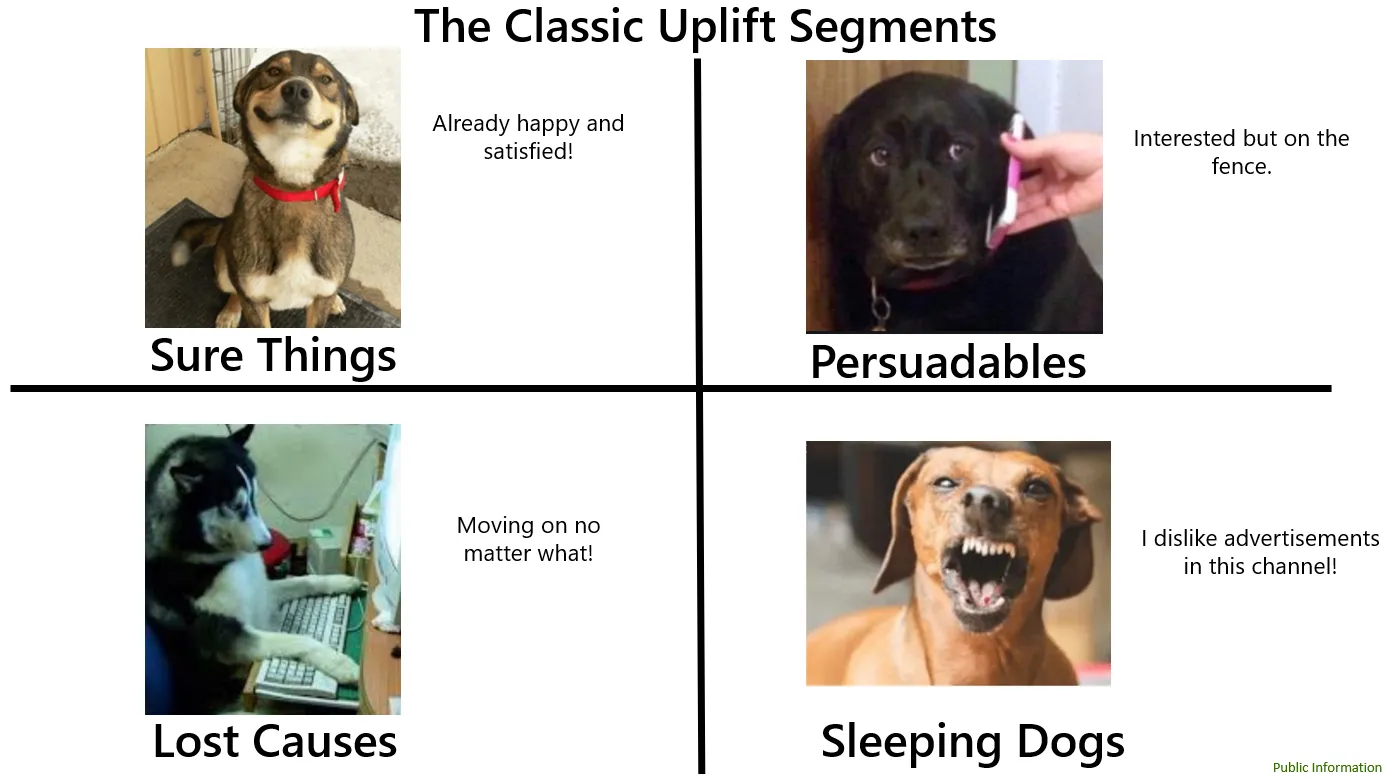      source:https://towardsdatascience.com/a-quick-uplift-modeling-introduction-6e14de32bfe0


* **Persuadables:** Customers that will purchase only if they receive an offer
* **Lost Causes:** Customer that won’t purchase in any case
* **Sure Things:** Customers that will purchase without an offer
* **Control Non-Responders:** Customers that will not purchase if they don’t receive an offer

> The premise behind uplift modeling is that it only makes sense to send marketing interventions to persuadables, because they are the only group where targeting them gives a better outcome than not targeting them. Sending marketing interventions to customers who are sure things or lost causes is a waste of resources, and an opportunity cost if you are constrained by the number of interventions you can send. Worse still, sending them to sleeping dogs will actually decrease sales.  https://www.ambiata.com/blog/2020-07-07-uplift-modeling/

In [4]:
df.head(5)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [5]:
def grab_col_names(dataframe, cat_th=10, car_th=20):

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [6]:
cat_cols, num_cols, cat_but_car=grab_col_names(df)

Observations: 64000
Variables: 9
cat_cols: 7
num_cols: 2
cat_but_car: 0
num_but_cat: 4


In [7]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        colors = ["#202240","#F5801A","#808080","#838496"]
        sns.set_palette(sns.color_palette(colors))
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()


           zip_code      Ratio
Surburban     28776  44.962500
Urban         25661  40.095312
Rural          9563  14.942187
##########################################


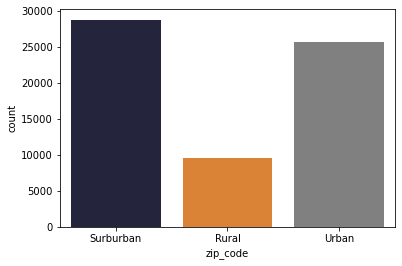

              channel      Ratio
Web             28217  44.089062
Phone           28021  43.782812
Multichannel     7762  12.128125
##########################################


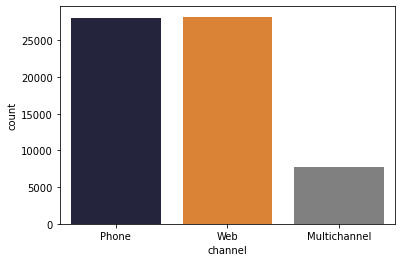

                 offer      Ratio
Buy One Get One  21387  33.417187
Discount         21307  33.292187
No Offer         21306  33.290625
##########################################


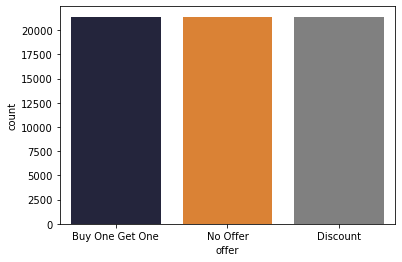

   used_discount      Ratio
1          35266  55.103125
0          28734  44.896875
##########################################


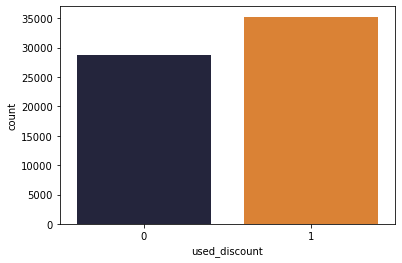

   used_bogo      Ratio
1      35182  54.971875
0      28818  45.028125
##########################################


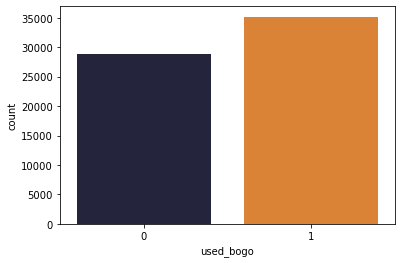

   is_referral   Ratio
1        32144  50.225
0        31856  49.775
##########################################


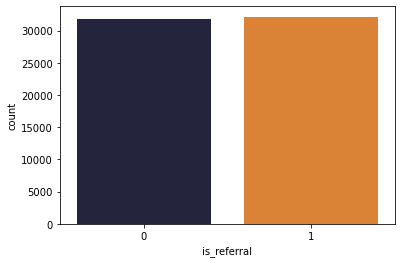

   conversion      Ratio
0       54606  85.321875
1        9394  14.678125
##########################################


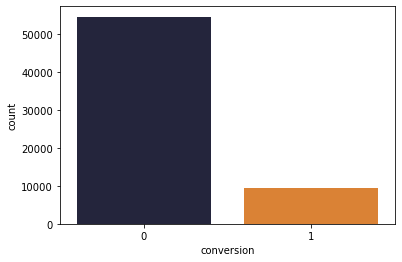

In [8]:
for col in cat_cols:
    cat_summary(df, col, plot=True)

In [9]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        colors = [ "#F5801A","#E3CFC2", "#202240", "#FFFFFF", "#838496"]
        sns.set_palette(sns.color_palette(colors))
        sns.histplot(x=dataframe[numerical_col], data=dataframe)
        plt.show()


count    64000.000000
mean         5.763734
std          3.507592
min          1.000000
5%           1.000000
10%          1.000000
20%          2.000000
30%          3.000000
40%          4.000000
50%          6.000000
60%          7.000000
70%          9.000000
80%         10.000000
90%         10.000000
95%         11.000000
99%         12.000000
max         12.000000
Name: recency, dtype: float64


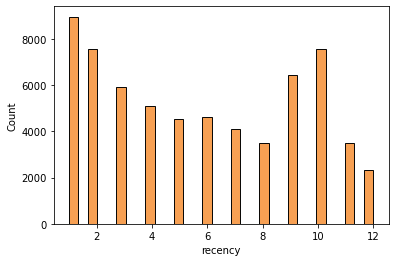

count    64000.000000
mean       242.085656
std        256.158608
min         29.990000
5%          29.990000
10%         29.990000
20%         50.298000
30%         80.187000
40%        115.280000
50%        158.110000
60%        210.810000
70%        281.210000
80%        382.032000
90%        561.194000
95%        747.262500
99%       1218.664300
max       3345.930000
Name: history, dtype: float64


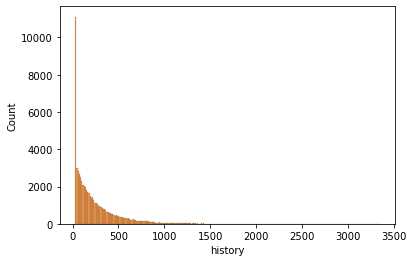

In [10]:
for col in num_cols:
    num_summary(df, col, plot=True)

In [11]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns

In [12]:
missing_values_table(df,na_name=False)


Empty DataFrame
Columns: [n_miss, ratio]
Index: []


In [13]:
#!pip install missingno

In [14]:
import missingno as msno


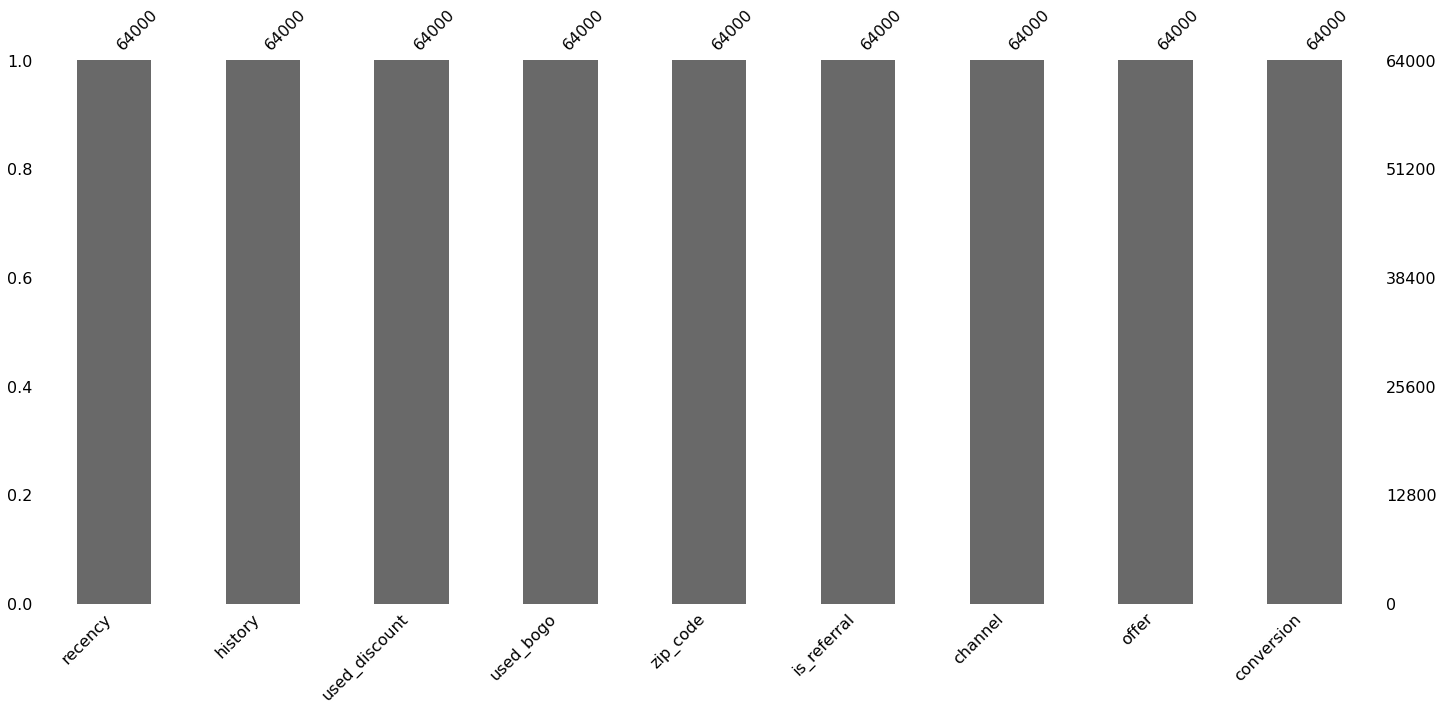

In [15]:
msno.bar(df)
plt.show()

In [16]:
df.head(5)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [17]:
def target(df):
    """Declare target class
    """
    #Lost Causes:
    df['customer_types'] = 0 
    #Sure Things:
    df.loc[(df.offer == 'No Offer') & (df.conversion != 0),'customer_types'] = 1 
    #Do not Disturbs:
    df.loc[(df.offer !='No Offer') & (df.conversion == 0),'customer_types'] = 2 
    #Persuadables:
    df.loc[(df.offer !='No Offer') & (df.conversion != 0),'customer_types'] = 3 
    return df

In [18]:
df=target(df)

In [19]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion,customer_types
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0,2
1,6,329.08,1,1,Rural,1,Web,No Offer,0,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0,2
3,9,675.83,1,0,Rural,1,Web,Discount,0,2
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0,2


In [20]:
df.customer_types.value_counts()

2    35562
0    19044
3     7132
1     2262
Name: customer_types, dtype: int64

In [21]:
def target_summary_with_cat(dataframe, target, categorical_col,plot=True):
    print(categorical_col)
    data=pd.DataFrame({"MODE": dataframe.groupby(categorical_col)[target].agg(pd.Series.mode),
                        "Count": dataframe[categorical_col].value_counts(),
                        "Ratio": 100 * dataframe[categorical_col].value_counts() / len(dataframe)})
    print(data,end="\n\n\n\n")
    if plot:
        colors = ["#202240","#F5801A","#808080","#838496"]
        sns.set_palette(sns.color_palette(colors))
        my_plot=sns.barplot(x=data.index,y=data["MODE"])
        my_plot.set(ylabel = "Most frequent", title =categorical_col)
        plt.show() 
        


In [22]:
def target(df):
    """Declare target class
    """
    #Lost Causes:
    df['customer_types'] = 0 
    #Sure Things:
    df.loc[(df.offer == 'No Offer') & (df.conversion != 0),'customer_types'] = 1 
    #Do not Disturbs:
    df.loc[(df.offer !='No Offer') & (df.conversion == 0),'customer_types'] = 2 
    #Persuadables:
    df.loc[(df.offer !='No Offer') & (df.conversion != 0),'customer_types'] = 3 
    return df

In [23]:
def target_summary_with_cat2(dataframe, target, categorical_col,plot=True):
    print(categorical_col)
    A=pd.DataFrame({"COUNT":dataframe.groupby(target)[categorical_col].value_counts()}).reset_index()

    if plot:  
        sns.catplot(x=target, y="COUNT", hue=categorical_col, data=A, kind='bar',height=4, aspect = 2)
        plt.xticks([0,1,2,3], ['Lost Causes', 'Sure Things', 'Do not Disturbs','Persuadables'])
        plt.show()


zip_code


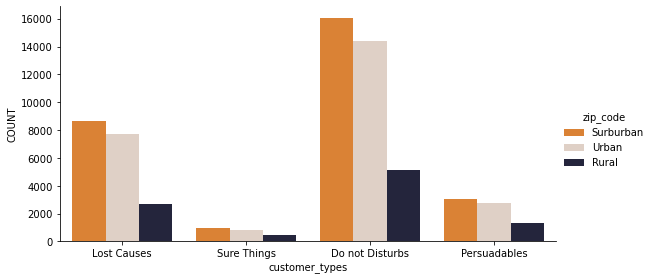

channel


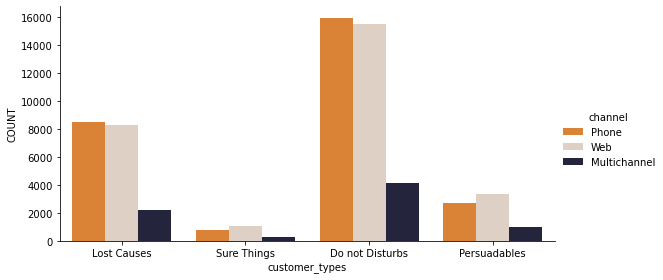

offer


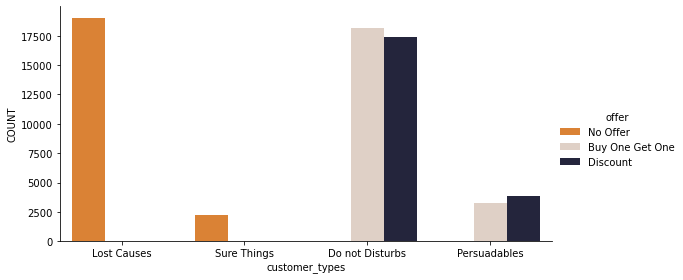

used_discount


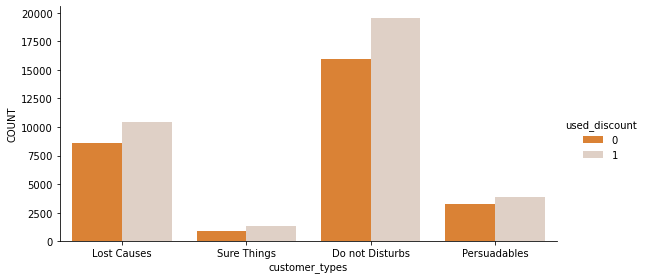

used_bogo


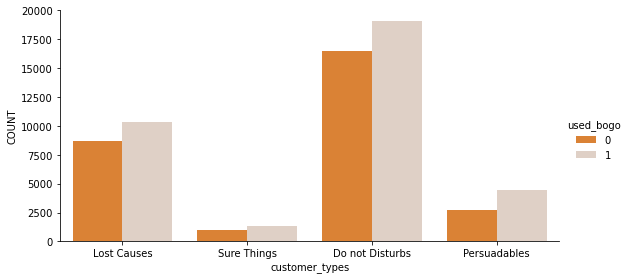

is_referral


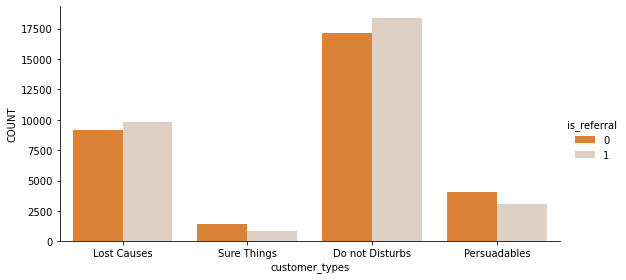

conversion


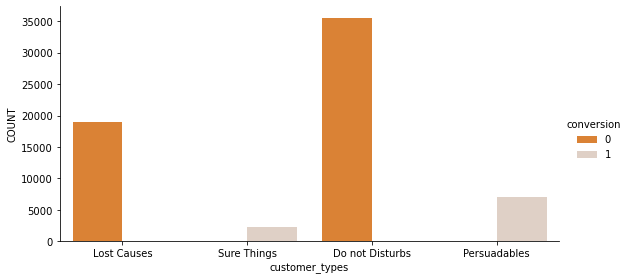

In [24]:
for col in cat_cols:
    target_summary_with_cat2(df,"customer_types",col,plot=True)


In [25]:
df.dtypes

recency             int64
history           float64
used_discount       int64
used_bogo           int64
zip_code           object
is_referral         int64
channel            object
offer              object
conversion          int64
customer_types      int64
dtype: object

In [26]:
pd.DataFrame({"mean":df.groupby("customer_types")['history'].mean()})

,mean
customer_types,
0,235.229693
1,288.475482
2,235.127903
3,280.372639


In [27]:
def target_summary_with_num(dataframe, target, numerical_col,plot=True):
    
    data=pd.DataFrame({"mean":dataframe.groupby(target)[numerical_col].mean()})
    print(data,end="\n\n\n\n")
    
    
    if plot:
        colors = ["#202240","#F5801A","#808080","#838496"]
        sns.set_palette(sns.color_palette(colors))
        my_plot=sns.barplot(x=data.index,y=data["mean"])
        my_plot.set(ylabel =numerical_col+" average", title =numerical_col)
        plt.xticks([0,1,2,3], ['Lost Causes', 'Sure Things', 'Do not Disturbs','Persuadables'])
        plt.show() 

In [28]:
num_cols

['recency', 'history']

                    mean
customer_types          
0               5.849874
1               4.906278
2               5.884624
3               5.202888





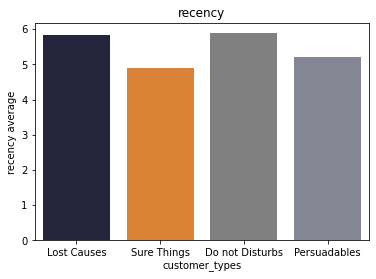

                      mean
customer_types            
0               235.229693
1               288.475482
2               235.127903
3               280.372639





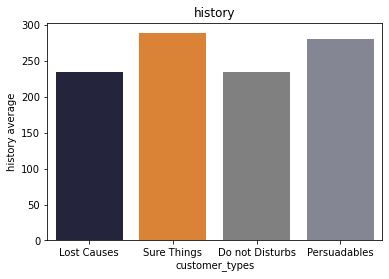

In [29]:
for col in num_cols:
    target_summary_with_num(df,"customer_types",col,plot=True)

In [30]:
def condition(x):
    if x =="Buy One Get One":
        return 1
    elif x =="Discount":
        return -1
    else:
        return 0
 

In [31]:
df["offer"].value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: offer, dtype: int64

In [32]:
df['offer'] = df['offer'].apply(condition)


In [33]:
df["offer"].value_counts()

 1    21387
-1    21307
 0    21306
Name: offer, dtype: int64

In [34]:
df["channel"].value_counts()

Web             28217
Phone           28021
Multichannel     7762
Name: channel, dtype: int64

In [35]:
def condition(x):
    if x =="Web":
        return 1
    elif x =="Phone":
        return 2
    else:
        return 3
 

In [36]:
df['channel'] = df['channel'].apply(condition)

In [37]:
df["zip_code"].value_counts()

Surburban    28776
Urban        25661
Rural         9563
Name: zip_code, dtype: int64

In [38]:
def condition(x):
    if x =="Surburban":
        return 1
    elif x =="Urban":
        return 2
    else:
        return 3

In [39]:
df['zip_code'] = df['zip_code'].apply(condition)

In [40]:
df["zip_code"].value_counts()

1    28776
2    25661
3     9563
Name: zip_code, dtype: int64

In [41]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion,customer_types
0,10,142.44,1,0,1,0,2,1,0,2
1,6,329.08,1,1,3,1,1,0,0,0
2,7,180.65,0,1,1,1,1,1,0,2
3,9,675.83,1,0,3,1,1,-1,0,2
4,2,45.34,1,0,2,0,1,1,0,2


In [42]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.90):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show()
    return drop_list


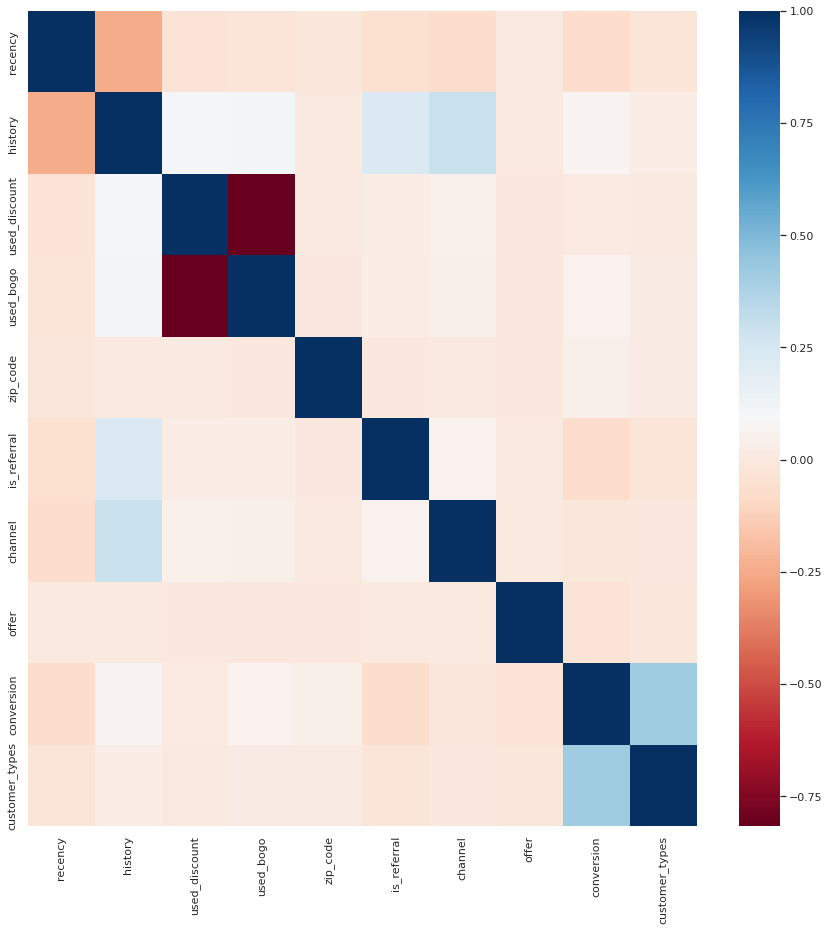

In [43]:

drop_list = high_correlated_cols(df, plot=True)


In [44]:
drop_list

[]

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

train_cols = df.columns.difference(['customer_types','conversion'])
X = df[train_cols]
y = df['customer_types']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
  

In [46]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


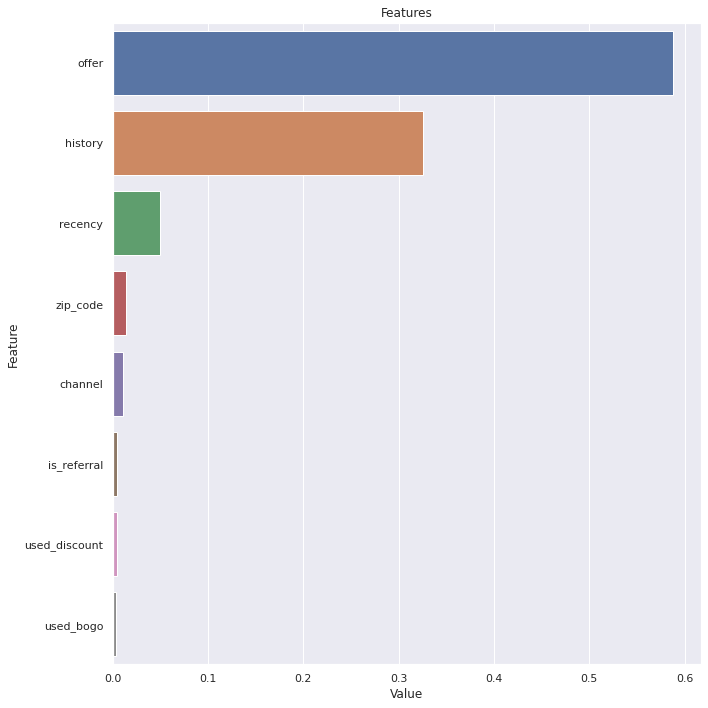

In [47]:
plot_importance(rf_model, X_train)

In [48]:
def base_models(X, y, scoring="accuracy"):
    print("Base Models....")
    classifiers = [
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier()),
                   ('LightGBM', LGBMClassifier()),
                   ('CatBoost', CatBoostClassifier(verbose=False))
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

In [49]:
base_models(X, y, scoring="accuracy")

Base Models....
accuracy: 0.7624 (CART) 
accuracy: 0.7965 (RF) 
accuracy: 0.8532 (Adaboost) 
accuracy: 0.853 (GBM) 
accuracy: 0.8493 (XGBoost) 
accuracy: 0.852 (LightGBM) 
accuracy: 0.8513 (CatBoost) 


In [58]:
rf_params = {"max_depth": [5, 8, None],#Default=None If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
             "max_features": [3, 5, 7, "auto"],#default=”sqrt”
             "min_samples_split": [2, 5, 8],#default=2
             "n_estimators": [100, 200, 300] #default=100
              }

In [59]:
 gbm_params = {"learning_rate": [0.01, 0.1], #default=0.1
               "max_depth": [3, 8, 10],#default=3 
               "n_estimators": [100, 500],#default=100  
               "subsample": [1, 0.5, 0.7] # default=1.0 
               } 

In [60]:
xgboost_params = {"learning_rate": [0.1, 0.01],# default=0.3                                            
                 "max_depth": [5, 8],#default=6 ,
                 "n_estimators": [100, 250, 400],#default=100
                 "colsample_bytree": [0.7, 1] #default=1
                 }

In [61]:
lgbm_params = {"max_depth":[3,5,10],
               "num_leaves":[8,70,100],
                "learning_rate": [0.01, 0.1, 0.3],
                "n_estimators": [200, 300,400]
                }

In [62]:
catboost_params = {"iterations": [10, 200, 500], #default=500
                   "learning_rate": [0.001, 0.01,0.5],
                   "depth": [4,6,8] #default=6
                  }

In [63]:
adaboost_params = { "n_estimators": [12, 30, 50],#default=50
                   "learning_rate": [(0.97 + x / 100) for x in range(0, 8)],#default=1
                   }

In [64]:
classifiers = [
                ("RF", RandomForestClassifier(),rf_params),
                ('Adaboost', AdaBoostClassifier(),adaboost_params),
                ('GBM', GradientBoostingClassifier(),gbm_params ),
                ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'),xgboost_params),
                ('LightGBM', LGBMClassifier(),lgbm_params),
                ('CatBoost', CatBoostClassifier(verbose=False),catboost_params)
                ]


def hyperparameter_optimization2(X, y, cv=3, scoring="roc_auc"):
    print("Hyperparameter Optimization....")
    best_models = {}
    for name, classifier, params in classifiers:
        print(f"########## {name} ##########")
        cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")

        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(X, y)
        final_model = classifier.set_params(**gs_best.best_params_)

        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        
        best_models[name] = final_model
        
    return best_models

In [65]:
best_models=hyperparameter_optimization2(X, y, cv=3, scoring="accuracy")

Hyperparameter Optimization....
########## RF ##########
accuracy (Before): 0.7969


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


accuracy (After): 0.8532
RF best params: {'max_depth': 5, 'max_features': 3, 'min_samples_split': 2, 'n_estimators': 100}

########## Adaboost ##########
accuracy (Before): 0.8532
accuracy (After): 0.8532
Adaboost best params: {'learning_rate': 0.97, 'n_estimators': 12}

########## GBM ##########
accuracy (Before): 0.853
accuracy (After): 0.8532
GBM best params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}

########## XGBoost ##########
accuracy (Before): 0.8493


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


accuracy (After): 0.8532
XGBoost best params: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}

########## LightGBM ##########
accuracy (Before): 0.852
accuracy (After): 0.8532
LightGBM best params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'num_leaves': 8}

########## CatBoost ##########
accuracy (Before): 0.8513
accuracy (After): 0.8532
CatBoost best params: {'depth': 4, 'iterations': 10, 'learning_rate': 0.001}



In [66]:
best_models


{'RF': RandomForestClassifier(max_depth=5, max_features=3),
 'Adaboost': AdaBoostClassifier(learning_rate=0.97, n_estimators=12),
 'GBM': GradientBoostingClassifier(learning_rate=0.01, subsample=1),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.7, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss', gamma=None,
               gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.01, max_bin=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, n_estimators=100, n_jobs=None,
               num_parallel_tree=None, predictor=None, random_state=None,
               reg_alpha=None, reg_lambda=None, ...),
 'LightGBM': LGBMClassifier(learning

In [71]:
lgbm_model=LGBMClassifier(learning_rate=0.01, max_depth=3, n_estimators=200, num_leaves=8)


In [73]:
# Create new dataframe
result = pd.DataFrame(X_test).copy()    
# Fit the model
uplift_model \
= lgbm_model.fit(X_train.drop('offer', axis=1), y_train)
uplift_proba \
= uplift_model.predict_proba(X_test.drop('offer', axis=1))
result['proba_LostCauses'] = uplift_proba[:,0] 
result['proba_SureThings'] = uplift_proba[:,1] 
result['proba_DonotDisturbs'] = uplift_proba[:,2] 
result['proba_Persuadables'] = uplift_proba[:,3]
result['uplift_score'] = result.eval('\
proba_LostCauses/(proba_LostCauses+proba_SureThings) \
+ proba_Persuadables/(proba_DonotDisturbs+proba_Persuadables) \
- proba_DonotDisturbs/(proba_DonotDisturbs+proba_Persuadables) \
- proba_SureThings/(proba_LostCauses+proba_SureThings)')  
# Put the result 
result['target_class'] = y_test

In [76]:
# Functions to build the Uplift model and visualize the QINI Curve
def qini_rank(uplift:pd.DataFrame):
    """Rank the data by the uplift score
    """
    # Creat new dataframe
    ranked = pd.DataFrame({'n':[], 'target_class':[]})
    ranked['target_class'] = uplift['target_class']
    ranked['uplift_score'] = uplift['uplift_score']
    
    
    # Add proportion
    ranked['n'] = ranked.uplift_score.rank(pct=True, ascending=False)
    # Data Ranking   
    ranked = ranked.sort_values(by='n').reset_index(drop=True)
    return ranked


def qini_eval(ranked:pd.DataFrame):
    """Evaluate the uplift value with the QINI criterion
    """
    uplift_model, random_model = ranked.copy(), ranked.copy()
    # Using Treatment and Control Group to calculate the uplift (Incremental gain)
    C, T = sum(ranked['target_class'] <= 1), sum(ranked['target_class'] >= 2)
    ranked['Sure_Things'] = 0
    ranked['Persuadables'] = 0
    ranked.loc[ranked.target_class == 1,'Sure_Things'] = 1
    ranked.loc[ranked.target_class == 3,'Persuadables'] = 1
    ranked['Sure_Things/c'] = ranked.Sure_Things.cumsum() / C
    ranked['Persuadables/t'] = ranked.tr.cumsum() / T
    # Calculate and put the uplift and random value into dataframe
    uplift_model['uplift'] = round(ranked['Persuadables/t'] - ranked['Sure_Things/c'],5)
    random_model['uplift'] = round(ranked['n'] * uplift_model['uplift'].iloc[-1],5)
    
    
    # Add q0
    q0 = pd.DataFrame({'n':0, 'uplift':0, 'target_class': None}, index =[0])
    uplift_model = pd.concat([q0, uplift_model]).reset_index(drop = True)
    random_model = pd.concat([q0, random_model]).reset_index(drop = True)  
    # Add model name & concat
    uplift_model['model'] = 'Uplift model'
    random_model['model'] = 'Random model'
    merged = pd.concat([uplift_model, random_model]).sort_values(by='n').reset_index(drop = True)
    return merged


def qini_plot(merged:pd.DataFrame):
    """Plot the QINI
    """
    # plot the data
    ax = sns.lineplot(x='n', y='uplift', hue='model', data=merged,
                      style='model', palette=['red','grey'])
    
    
    # Plot settings
    sns.set_style('whitegrid')
    handles, labels = ax.get_legend_handles_labels()
    plt.xlabel('Proportion targeted',fontsize=15)
    plt.ylabel('Uplift',fontsize=15)
    plt.subplots_adjust(right=1)
    plt.subplots_adjust(top=1)
    plt.legend(fontsize=12)
    ax.tick_params(labelsize=15)
    ax.legend(handles=handles[1:], labels=labels[1:], loc='upper right')
    return ax


def qini(uplift:pd.DataFrame):
    """Combine all functions
    """
    ranked = qini_rank(uplift)
    merged = qini_eval(ranked)
    ax = qini_plot(merged)
    return ax

In [78]:
qini(df)
plt.title('Qini Curve - Buy One Get One',fontsize=20)

KeyError: 'target_class'

In [ ]:
 #CN:
    df['target_class'] = 0 
    #CR:
    df.loc[(df.treatment == 0) & (df.target != 0),'target_class'] = 1 
    #TN:
    df.loc[(df.treatment != 0) & (df.target == 0),'target_class'] = 2 
    #TR:
    df.loc[(df.treatment != 0) & (df.target != 0),'target_class'] = 3 

In [ ]:
[0,1,2,3], ['Lost Causes', 'Sure Things', 'Do not Disturbs','Persuadables']

NameError: name 'uplift' is not defined